In [1]:
import os

os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_TRACING"] = "true"
# use default project.
#os.environ["LANGSMITH_PROJECT"] = f"classification - {unique_id}"

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(model="gemini-2.0-flash-001", model_provide="google_vertexai")

In [3]:
from langchain_google_vertexai import VertexAIEmbeddings

embeddings = VertexAIEmbeddings(model="text-embedding-004")

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Flow

In this RAG, we are going to build an execution graph.  A graph consists of edges and nodes. The graph state is passed along the way, and updated by each node. So we need a well-defined state, and node toplogy. Here, we have a very simple static linear execution flow. The node itself uses llm in various stage (embedding, augumented generation).

Please note that with the static graph execution flow, we don't need graph, we can write  code that calls function by function.

**Graph has state, and method to build the toplogy: edge and nodes**

In this example, we don't have tool node and automatically tool call. Once we have tool nodes, the **execution flow is dynamic**. The llm decides what tool node to call, and provides
arguments to match tools parameters. 

In the static graph, we will have two steps. 
1: Retrieve docs based on question.  For this, we need have all document indexed to vector store
2: Send querys, and docs to llm , and let llm to formulate an answer. 



In [10]:
# prepare the vector store so we can retrieve documents. 
import bs4
from langchain_core.documents import Document
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs= dict(parse_only=bs4.SoupStrainer(
        class_=("post-content", "post-title", "post-header")
    )
                   ))

docs = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
splits =splitter.split_documents(docs)
one_third = len(splits)/3
for index, split in enumerate(splits):
    if index < one_third:
        split.metadata['section']='begin'
    elif index < one_third *2:
        split.metadata['section']='middle'
    else:
        split.metadata['section']='end'



In [ ]:
vector_store.add_documents(documents=splits)

In [42]:
from pydantic import BaseModel, Field
from typing import List, Literal, Annotated, Optional, TypedDict
from langchain_core.prompts import PromptTemplate
from langgraph.graph import START, StateGraph
prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. Use the following pieces of
    retrieved context to answer the question. If you don't know the answer,
    just say that you don't know. Use three sentences maximum and
    keep the answer concise.
    
Question: {question} 
Context: {context} 
Answer:""")

class Search(BaseModel):
    query: str =Field(..., description="the query to search")
    section: Optional[Literal["begin", "middle", "end"]] = Field(None, 
                                                                 description="what section we should search from")

                             
class State(TypedDict):
    question: Annotated[str, ..., "question from user"]
    search: Annotated[Optional[Search], ..., "transformed query"]
    context: Annotated[Optional[List[Document]], ..., "found documents"]
    answer: Annotated[Optional[str], ..., "answer from model"]


def transform_query (state: State):
    strutured_llm = llm.with_structured_output(Search)
    resp= strutured_llm.invoke(state['question'])
    return {'search': resp}
    
def retrieve(state: State):
    search = state['search']
    found_splitts = vector_store.similarity_search(search.query,
                                                  filter=lambda doc : doc.metadata['section']==search.section if search.section else True
                                                  )
    return {'context': found_splitts}

def gen(state: State):
    content = "\n\n".join( doc.page_content for doc in state['context'])
    prompt_instance = prompt.invoke({"question": state['question'], "context":content})
    resp = llm.invoke(prompt_instance)
    return {'answer': resp.content}




In [48]:
graph_builder = StateGraph(State).add_sequence([transform_query, retrieve, gen])
graph_builder.add_edge(START, 'transform_query')
graph= graph_builder.compile()

In [51]:
state ={'question':"What is task decomposition?"}
resp=graph.invoke(state)

query='task decomposition' section='begin'


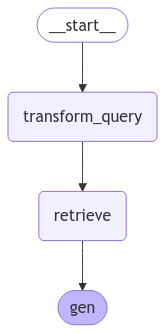

In [49]:
from IPython.display import Image, display, Markdown
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
display(Markdown(resp['answer']))

Task decomposition involves breaking down large tasks into smaller, manageable subgoals to efficiently handle complex tasks. It can be achieved through methods like chain of thought prompting, task-specific instructions, or human input. This approach transforms big tasks into multiple manageable ones, shedding light on the model’s thinking process.
